In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import glob

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
LABELS = ["isFraud"]
all_files = glob.glob("lgbmodels/*.csv")
scores = np.zeros(len(all_files))
for i in range(len(all_files)):
    scores[i] = float('.'+all_files[i].split(".")[1])

In [3]:
top = scores.argsort()[::-1]
for i, f in enumerate(top):
    print(i,scores[f],all_files[f])

0 0.9493 lgbmodels\LB=0.9493.csv
1 0.9492 lgbmodels\lgb_group-0.9492.csv
2 0.9488 lgbmodels\lgb_491feats-0.9488.csv
3 0.9442 lgbmodels\Submission-.9442.csv
4 0.9408 lgbmodels\submission-.9408.csv


In [4]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in top]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols

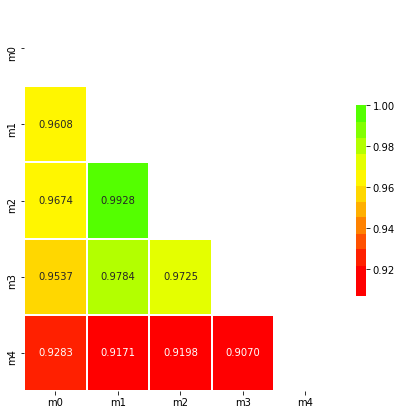

In [5]:
# check correlation
corr = concat_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.5})

In [6]:
mean_corr = corr.mean()
mean_corr = mean_corr.sort_values(ascending=True)
mean_corr = mean_corr[:5]
mean_corr

m4    0.934450
m0    0.962036
m3    0.962318
m1    0.969822
m2    0.970501
dtype: float64

In [7]:
m_gmean = 0
for n in mean_corr.index:
    m_gmean += np.log(concat_sub[n])
m_gmean = np.exp(m_gmean/len(mean_corr))

In [8]:
top_mean = 0
s = 0
for n in [0,2,3,4]:
    top_mean += concat_sub.iloc[:,n]*scores[top[n]]
    s += scores[top[n]]
top_mean /= s

In [9]:
m_gmean = np.exp(0.4*np.log(m_gmean) + 0.6*np.log(top_mean))

In [10]:
describe(m_gmean)

DescribeResult(nobs=506691, minmax=(0.00015745292485053351, 0.9978239924078632), mean=0.02733788781089986, variance=0.012699209520964282, skewness=7.064289611309327, kurtosis=51.67678895443187)

In [11]:
concat_sub['isFraud'] = m_gmean
# concat_sub[['isFraud']].to_csv('en_results/stack_gmean25.csv')
concat_sub[['isFraud']].to_csv('en_results/best_cv_gmean.csv')